# 1. Small Circle inside Large Circle

El objetivo de esta sección es experimentar con algunos modelos no-lineales sobre un problema de juguete
generado para visualizar algoritmos de clustering. Se trata de un problema de clasificación a todas luces
linealmente inseparable, en el sentido que, si denotamos por $x \in \mathcal{R}^2$ un patrón de entrada y por $y \in \{0, 1\}$ su correspondiente etiqueta, no existen $w \in \mathcal{R}^2,b \in \mathcal{R}$ tal que $y(w^Tx + b) \ge \rho > 0$. El problema nos permite hacer un recorrido rápido por las grandes ideas en la búsqueda de la no linealidad.

## a. Construcción de la data de entrenamiento y prueba




In [3]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)
    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
    np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp),
    np.ones(n // 2, dtype=np.intp)])
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [30]:
import matplotlib.pyplot as plt


def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    f, axis = plt.subplots(1, 1, sharex='col', sharey='row',figsize=(12, 8))
    axis.scatter(X_train[:,0],X_train[:,1],s=30,c=Y_train,zorder=10,cmap='summer_r')
    axis.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,zorder=10,cmap='winter_r')
    
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
    if model_type == 'tree':
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    elif model_type == 'ann':
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    else: raise ValueError('model type not supported')
    Z = Z.reshape(XX.shape)
    Zplot = Z > 0.5
    axis.pcolormesh(XX, YY, Zplot ,cmap='rainbow')
    axis.contour(XX, YY, Z, alpha=1, colors=["k", "k", "k"], linestyles=["--", "-", "--"],
    levels=[-2, 0, 2])
    plt.show()

Se generan los datos de entrenamiento y pruebas usando la funcion do_circles() definida anteriormente.

In [31]:
# Se obtienen los datos de entrenamiento y pruebas según lo requerimientos especificados
X_train, Y_train, X_test, Y_test = do_circles()

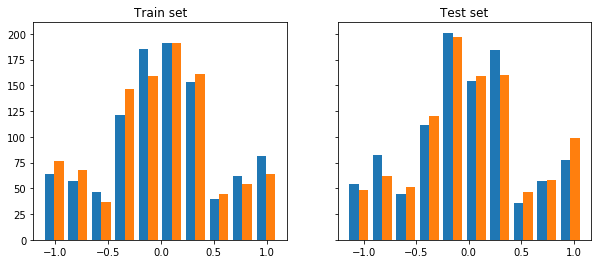

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,4))
ax1.hist(X_train)
ax2.hist(X_test)
ax1.set_title('Train set')
ax2.set_title('Test set')
f.subplots_adjust(hspace=0.3)
plt.show()

In [33]:
print("===============================================")
print("Elementos por clase en la data de entrenamiento")
print("Clase 0:", list(Y_train).count(0))
print("Clase 1:", list(Y_train).count(1))
print("===============================================")
print("===============================================")
print("Elementos por clase en la data de pruebas")
print("Clase 0:", list(Y_test).count(0))
print("Clase 1:", list(Y_test).count(1))
print("===============================================")

Elementos por clase en la data de entrenamiento
Clase 0: 493
Clase 1: 507
Elementos por clase en la data de pruebas
Clase 0: 507
Clase 1: 493


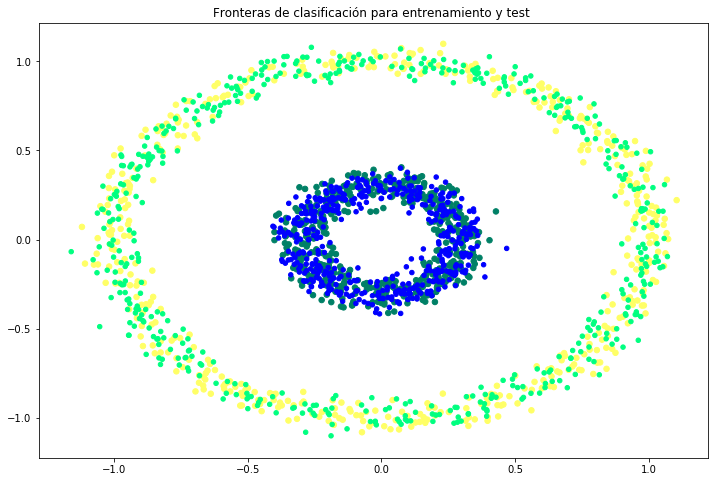

In [34]:
f, axis = plt.subplots(1, 1, sharex="col", sharey="row",figsize=(12, 8))
axis.scatter(X_train[:,0],X_train[:,1],s=30,c=Y_train,zorder=10,cmap="summer_r") #Amarillo y verde oscuro
axis.scatter(X_test[:,0],X_test[:,1],s=20,c=Y_test,zorder=10,cmap="winter_r") #verde claro y azul
axis.set_title('Fronteras de clasificación para entrenamiento y test ')
plt.show()

## b. Perceptron  - 1 neurona

A continuación se intentara resolver el problema usando solo una neurona sin capas intermedias. Se busca demostrar de forma experimental que al tener un solo nodo en nuestra "red neuronal", esta no será capaz de resolver el problema ya que no tienen los grados de libertad necesarios para lidiar con un problema de clasificación no lineal. 

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=25, batch_size=100, verbose=1)

scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

Epoch 1/25
1000/1000 [==============================] - 1s - loss: 7.5180 - acc: 0.0520     
Epoch 2/25
1000/1000 [==============================] - 0s - loss: 7.8596 - acc: 0.0000e+00     
Epoch 3/25
1000/1000 [==============================] - 0s - loss: 7.8596 - acc: 0.0000e+00     
Epoch 4/25
1000/1000 [==============================] - 0s - loss: 7.8596 - acc: 0.0000e+00     
Epoch 5/25
1000/1000 [==============================] - 0s - loss: 7.8596 - acc: 0.0000e+00     
Epoch 6/25
1000/1000 [==============================] - 0s - loss: 7.8596 - acc: 0.0000e+00     

In [36]:
print("Test accuracy:", test_acc )

Test accuracy: 0.0


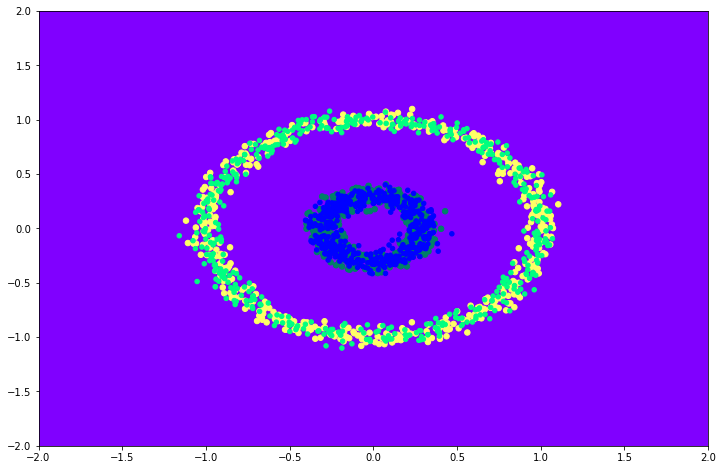

In [37]:
plot_classifier(model,X_train,Y_train,X_test,Y_test,model_type="ann")

Al probar con 25 epochs podemos ver que el accuracy del modelo no presenta ninguna mejora a medida que se van completando las iteraciones. Además al graficar el modelo entrenado podemos notar que en este no existe división alguna entre las fronteras de decisión (Todo el fondo es de un solo color).

Se medirá nuevamente el desempeño pero esta vez modificaremos algunos de los parámetros: La funcion de activacion ahora será "sigmoid", es decir una función no lineal y la cantidad de epochs será de 50. Con esto se pretende ver si el modelo presenta una mejora en su accuracy.

In [38]:
model = Sequential()
model.add(Dense(1, input_dim=X_train.shape[1], kernel_initializer='normal', activation='sigmoid'))
model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=50, batch_size=100, verbose=1)
scores = model.evaluate(X_test, Y_test)
test_acc = scores[1]

Epoch 1/50
1000/1000 [==============================] - 1s - loss: 0.6945 - acc: 0.4650     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 0.6939 - acc: 0.5120     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.6947 - acc: 0.5990     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.6925 - acc: 0.6270     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 0.6930 - acc: 0.5670     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 0.6938 - acc: 0.5090     

In [39]:
print("Test accuracy:", test_acc )

Test accuracy: 0.561


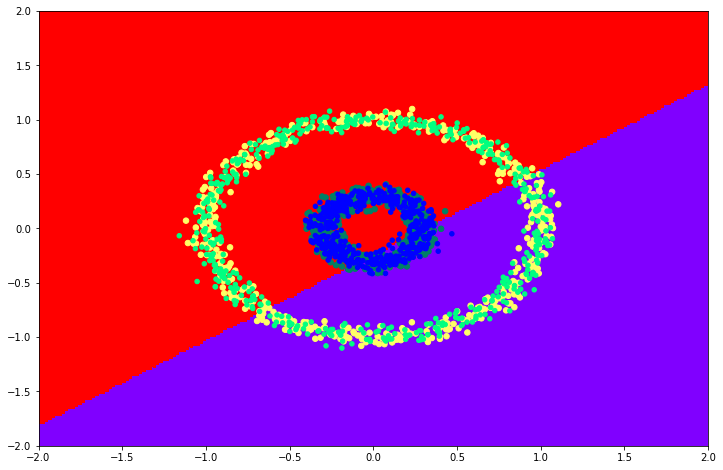

In [40]:
plot_classifier(model,X_train,Y_train,X_test,Y_test,model_type="ann")

Como podemos notar no existe ningún cambio en el accuracy del modelo, lo cual es esperable, ya que como se mencionó antes una sola neurona no dispone de los grados de libertad necesarios para abordar un problema de clasificación no lineal. 

En el siguiente punto probaremos con un perceptron de más neuronas y una capa escondida adicional.

## c. Red neuronal con 1 capa oculta

A continuación se busca demostrar experimentalmente que una red neuronal con más elementos es capaz de lograr mejores resultados que el modelo del punto anterior en este problema de clasificación no lineal. El siguiente modelo se dispondrá de una capa oculta y se hará variar la cantidad de neuronas de la primera capa junto con la cantidad de epoch con el fin de analizar cuánto afectan en el desempeño de nuestro modelo estos parámetros

In [41]:
def scores(ep,n_h,X_train, Y_train,X_test, Y_test):
    sc_tr = []
    sc_ts = []
    for i in range(len(n_h)):
        model = Sequential()
        model.add(Dense(n_h[i], input_dim=X_train.shape[1], kernel_initializer= "uniform", activation="relu"))
        model.add(Dense(1, kernel_initializer="uniform", activation="sigmoid"))
        model.compile(optimizer=SGD(lr=1), loss="mean_squared_error", metrics=["accuracy"])
        model.fit(X_train, Y_train, epochs=ep, batch_size=50, verbose=False)
        score1 = model.evaluate(X_train, Y_train)
        score2 = model.evaluate(X_test, Y_test)
        sc_tr.append(score1[0])
        sc_ts.append(score2[0])
    return sc_tr,sc_ts

En la cantidad de neuronas usamos potencias de 2 en el rango $\{2^1,2^5\}$, mientras que la cantidad de epocas de entrenamiento usaremos los valores $\{10,25,50\}$

In [42]:
# Se probara con distintos valores de neuronas
n_h=[2,4,8,16,32]
# Se probara con diferentes valores para el parametro epochs
ep = [10,25,50]

In [43]:
l_sc_train = []
l_sc_test = []
for i in range(len(ep)):
    sc1, sc2 = scores(ep[i],n_h,X_train, Y_train,X_test, Y_test)
    l_sc_train.append(sc1)
    l_sc_test.append(sc2)

 672/1000 [===================>..........] - ETA: 0s 

A continuación se presenta la grafica del error cuadrático medio obtenido para las diferentes redes con distintas cantidad de neuronas en el primer nivel y diferentes valores en la cantidad de epochs.

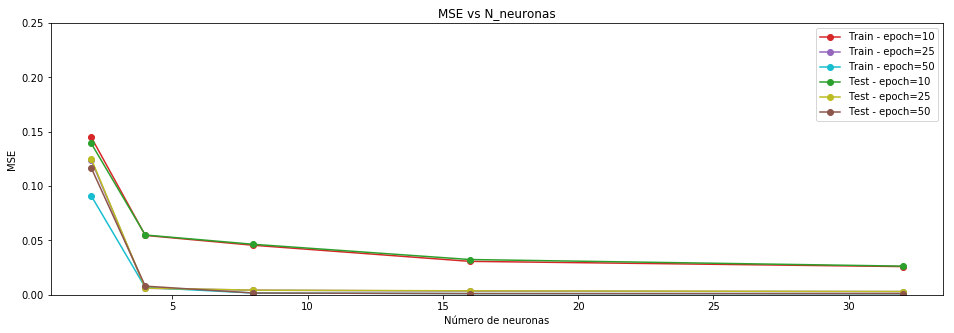

In [44]:
plt.figure(figsize=(16,5))
plt.xlabel("Número de neuronas")
plt.ylim((0,.25))
plt.ylabel("MSE")
plt.title("MSE vs N_neuronas")
plt.plot(n_h,l_sc_train[0], '-o',label= "Train - epoch=10",color="tab:red")
plt.plot(n_h,l_sc_train[1], '-o',label= "Train - epoch=25",color="tab:purple")
plt.plot(n_h,l_sc_train[2], '-o',label= "Train - epoch=50",color="tab:cyan")
plt.plot(n_h,l_sc_test[0], '-o',label= "Test - epoch=10",color="tab:green")
plt.plot(n_h,l_sc_test[1], '-o',label= "Test - epoch=25",color="tab:olive")
plt.plot(n_h,l_sc_test[2], '-o',label= "Test - epoch=50",color="tab:brown")
plt.legend(loc = "best")
plt.show()

Como podemos ver, a medida que aumentamos la cantidad de neuronas el error en el resultado de la predicción disminuye drásticamente en este modelo de dos capas. Podemos notar que a partir de las 4 neuronas y con un epoch mayor a 10 el error tiende a ser cero.

A continuación veremos gráficamente como queda la clasificación para algunos casos.

**2 neuronas - 50 epochs**

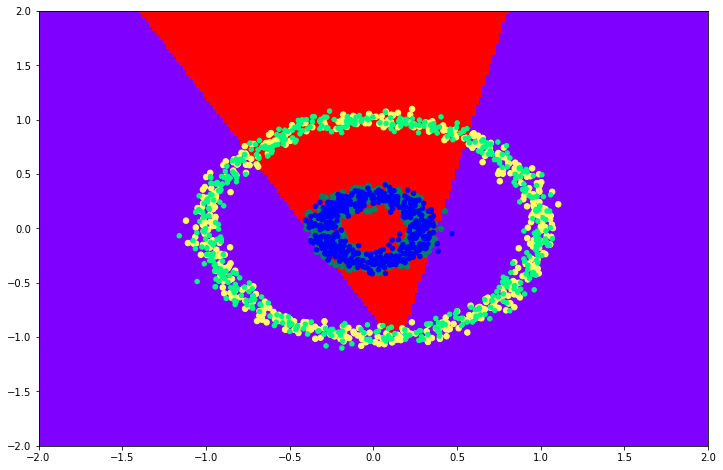

In [45]:
model3 = Sequential()
model3.add(Dense(2, input_dim=X_train.shape[1], kernel_initializer= "uniform", activation="relu"))
model3.add(Dense(1, kernel_initializer="uniform", activation="sigmoid"))
model3.compile(optimizer=SGD(lr=1), loss="mean_squared_error", metrics=["accuracy"])
model3.fit(X_train, Y_train, epochs=50, batch_size=50, verbose=False)
plot_classifier(model3,X_train,Y_train,X_test,Y_test,model_type="ann")

** 4 neuronas - 10 epochs**

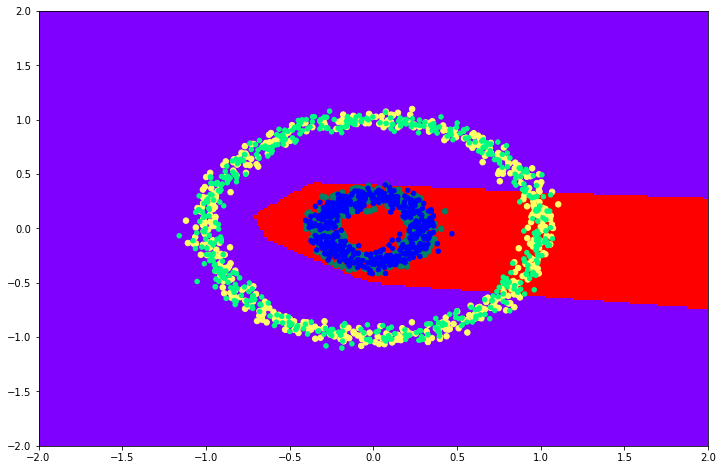

In [46]:
model4 = Sequential()
model4.add(Dense(4, input_dim=X_train.shape[1], kernel_initializer= "uniform", activation="relu"))
model4.add(Dense(1, kernel_initializer="uniform", activation="sigmoid"))
model4.compile(optimizer=SGD(lr=1), loss="mean_squared_error", metrics=["accuracy"])
model4.fit(X_train, Y_train, epochs=10, batch_size=50, verbose=False)
plot_classifier(model4,X_train,Y_train,X_test,Y_test,model_type="ann")

**32 neuronas - 50 epochs **

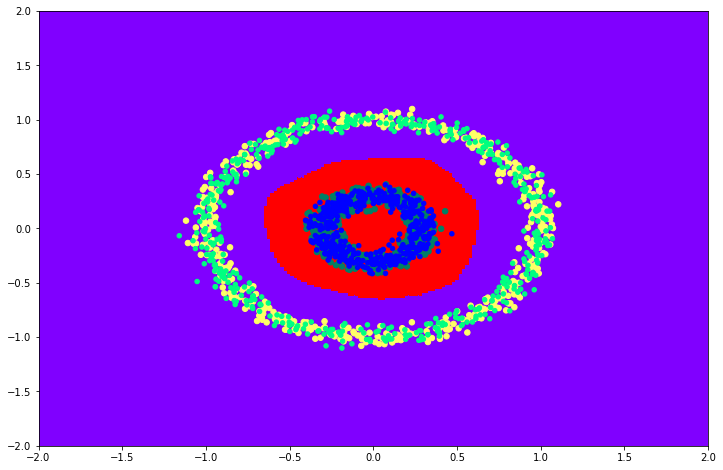

In [47]:
model5 = Sequential()
model5.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer= "uniform", activation="relu"))
model5.add(Dense(1, kernel_initializer="uniform", activation="sigmoid"))
model5.compile(optimizer=SGD(lr=1), loss="binary_crossentropy", metrics=["accuracy"])
model5.fit(X_train, Y_train, epochs=50, batch_size=50, verbose=False)
plot_classifier(model5,X_train,Y_train,X_test,Y_test,model_type="ann")

Con los resultados obtenidos podemos ver que el las redes neuronales son un metodo bastante poderoso para resolver problemas de clasificación no lineales, siempre y cuando dispongan de una cantidad suficiente de neuronas, y alguna capa escondida. En particular para efectos de nuestro problema solo basto con agregar unas pocos nodos, una cantidad razonable de epocas de entrenamiento y tener una capa oculta para conseguir resultados desde lo aceptable hasta lo optimo.

## d.  Clasificación mediante un stump

A continuación se busca demostrar que un stump (árbol de clasificación de 1 nivel) no será capaz de clasificar de forma correcta nuestro problema no lineal, para esto se presentaran variaciones en algunos de sus parámetros, con el fin de estudiar su comportamiento y ver el impacto en el rendimiento de este clasificador.

En una primera instancia se probara usando los valores:
* criterion = gini
* splitter = best

In [48]:
from sklearn.tree import DecisionTreeClassifier as Tree

clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=1)
clf.fit(X_train,Y_train)
y = clf.predict(X_test)
mse = np.mean(np.power(y - Y_test, 2))
acc_test = clf.score(X_test,Y_test)

print("Profundidad del arbol", clf.tree_.max_depth)
print("Test Accuracy = ",acc_test)
print("Test Mse", mse)

Profundidad del arbol 1
Test Accuracy =  0.67
Test Mse 0.33


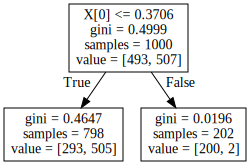

In [49]:
from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)
dot_data = tree.export_graphviz(clf, out_file=None,   
                         filled=True, rounded=True,  
                         special_characters=True)

graph

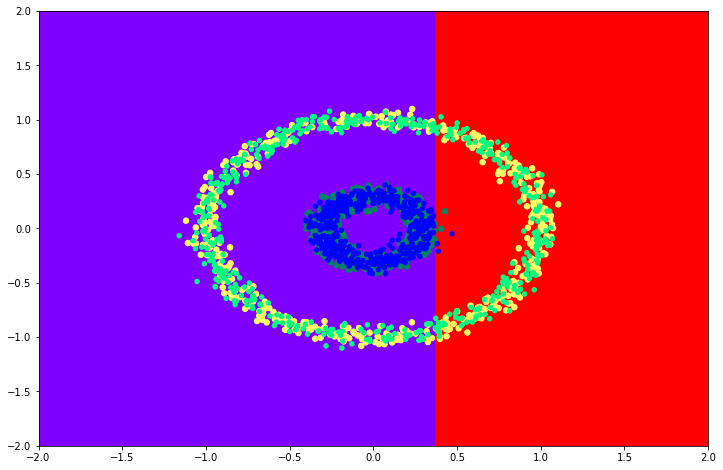

In [50]:
plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type="tree")

Como podemos ver el árbol trata de de clasificar de manera lineal separando el conjunto de datos mediante una recta vertical. Además podemos ver que el accuracy del obtenido es aceptable ya es 0.67, esto se puede ver explicado ya que el modelo que construimos esta dado con el mejor split.

A continuación se realizara otra prueba pero con los parametros:
* criterion = gini
* splitter = random

In [64]:
clf1=Tree(criterion="gini",splitter="random",random_state=1,max_depth=1)
clf1.fit(X_train,Y_train)
y = clf1.predict(X_test)
mse = np.mean(np.power(y - Y_test, 2))
acc_test = clf1.score(X_test,Y_test)

print("Profundidad del arbol", clf1.tree_.max_depth)
print("Test Accuracy = ",acc_test)
print("Test Mse", mse)

Profundidad del arbol 1
Test Accuracy =  0.621
Test Mse 0.379


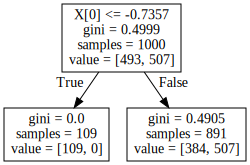

In [65]:
import graphviz 

dot_data = tree.export_graphviz(clf1, out_file=None) 
graph = graphviz.Source(dot_data)
dot_data = tree.export_graphviz(clf1, out_file=None,   
                         filled=True, rounded=True,  
                         special_characters=True)

graph

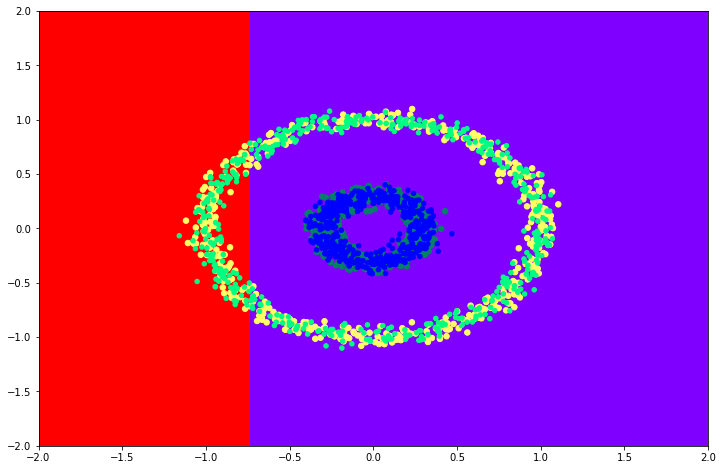

In [66]:
plot_classifier(clf1,X_train,Y_train,X_test,Y_test,model_type="tree")

Como podemos ver al usar el splitter random, tambien se hace un clasificación lineal, pero esta vez invirtio el corte realizado, además debido a esto el accuracy disminuyó en aproximadamente 0.05.

Como pudimos comprobar un árbol de un solo nivel es incapaz de resolver el problema ya que siempre realiza cortes lineales a la data, por lo que es imposible clasificar de forma correcta nuestra data no lineal.

## e. Árbol de clasificación con multiples niveles

En este apartado se busca comprobar empíricamente que al usar árboles de profundidad mayor a 1, estos son capaces de resolver nuestro problema de ejemplo. Para realizar esta tarea se probara realizando variaciones en la profundidad de nuestro árbol con el fin de evaluar el rendimiento de este, a través de sus error cuadratico medio. y su accuracy 

In [69]:
def mse_tree(max_depth,min_depth):
    l_test = []
    l_train = []
    score_train = []
    score_test = []
    for i in range(max_depth,min_depth+1):
        clf=Tree(criterion="gini",splitter="best",random_state=0,max_depth=i)
        clf.fit(X_train,Y_train)
        # score
        score_test.append(clf.score(X_test,Y_test))
        score_train.append(clf.score(X_train,Y_train))
        # prediccion conjunto de entrenamiento
        ypred_train = clf.predict(X_train)
        msetr = np.mean(np.power(ypred_train - Y_train, 2))
        l_train.append(msetr)
        # prediccion conjunto de pruebas
        ypred_test = clf.predict(X_test)
        msets = np.mean(np.power(ypred_test - Y_test, 2))
        l_test.append(msets)
    return l_train, l_test, score_test, score_train

mse_train, mse_test, tree_score_test, tree_score_train = mse_tree(2,20)

** Graficas MSE y Accuracy **

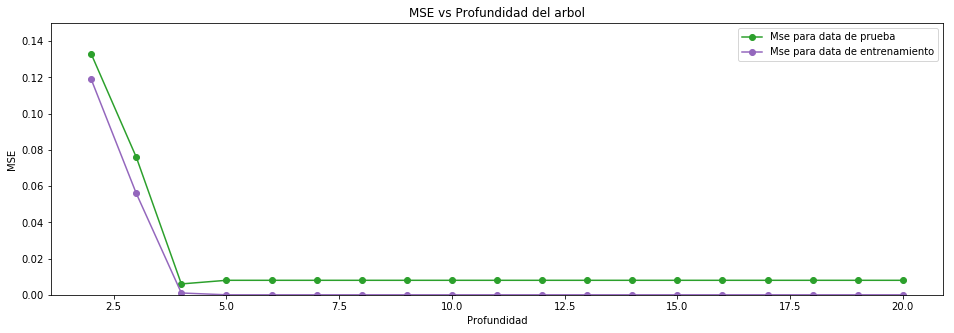

In [70]:
N_t = np.arange(2,21)
plt.figure(figsize=(16,5))
plt.xlabel("Profundidad")
plt.ylim((0,.15))
plt.ylabel("MSE")
plt.title("MSE vs Profundidad del arbol")
plt.plot(N_t,mse_test, '-o',label= "Mse para data de prueba",color="tab:green")
plt.plot(N_t,mse_train, '-o',label= "Mse para data de entrenamiento",color="tab:purple")
plt.legend(loc = "best")
plt.show()

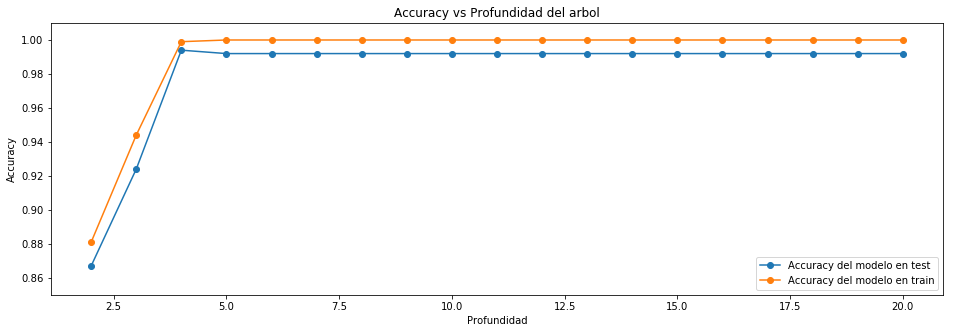

In [73]:
N_t = np.arange(2,21)
plt.figure(figsize=(16,5))
plt.xlabel("Profundidad")
plt.ylim((0.85,1.01))
plt.ylabel("Accuracy")
plt.title("Accuracy vs Profundidad del arbol")
plt.plot(N_t, tree_score_test, '-o', label = "Accuracy del modelo en test")
plt.plot(N_t, tree_score_train, '-o', label = "Accuracy del modelo en train")
plt.legend(loc = "best")
plt.show()

Finalmente graficamos algunos de los casos más representativos para apreciar como el árbol realiza la clasificación.

** Profundidad maxima = 2 **

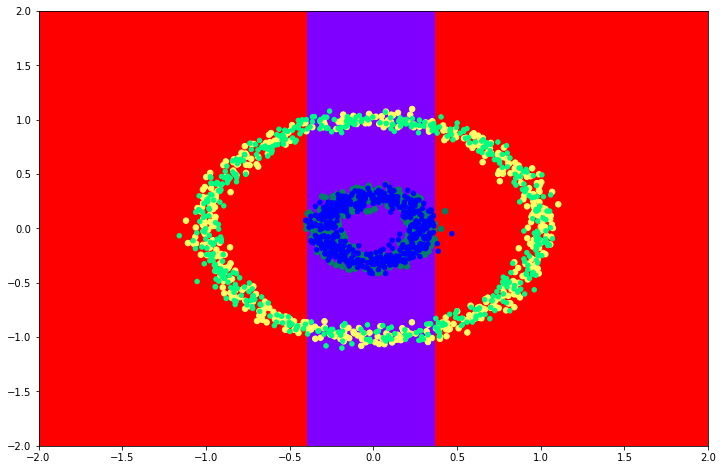

In [74]:
clf2=Tree(criterion="gini",splitter="best",random_state=0,max_depth=2)
clf2.fit(X_train,Y_train)
plot_classifier(clf2,X_train,Y_train,X_test,Y_test,model_type="tree")

** Profundidad maxima = 3**

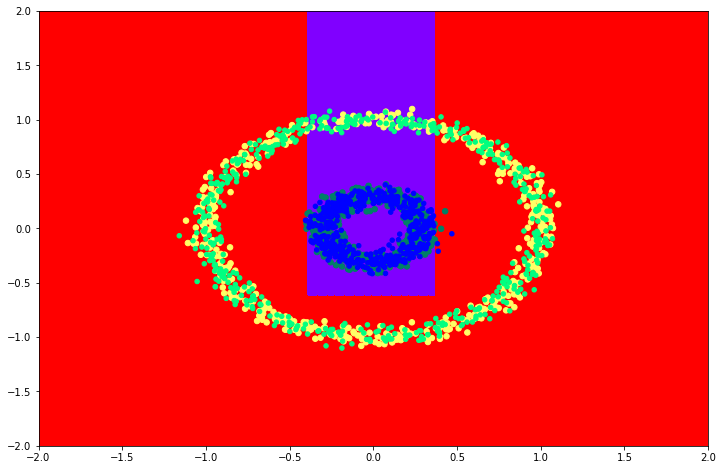

In [75]:
clf3=Tree(criterion="gini",splitter="best",random_state=0,max_depth=3)
clf3.fit(X_train,Y_train)
plot_classifier(clf3,X_train,Y_train,X_test,Y_test,model_type="tree")

** Profundidad maxima = 4**

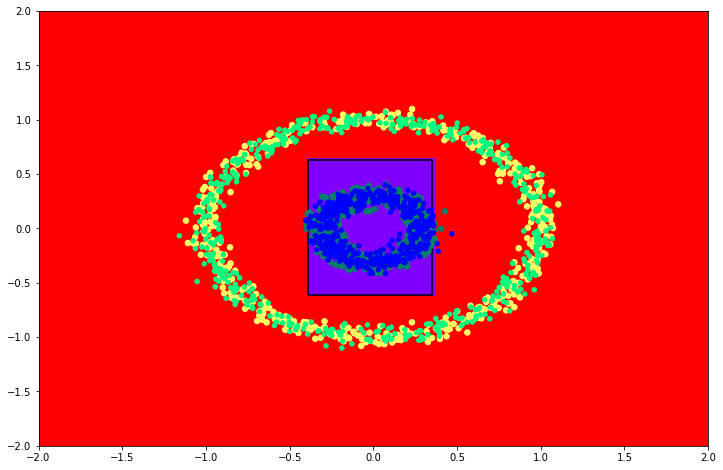

In [76]:
clf4=Tree(criterion="gini",splitter="best",random_state=0,max_depth=4)
clf4.fit(X_train,Y_train)
plot_classifier(clf4,X_train,Y_train,X_test,Y_test,model_type="tree")

** Profundidad maxima = 5  **                      

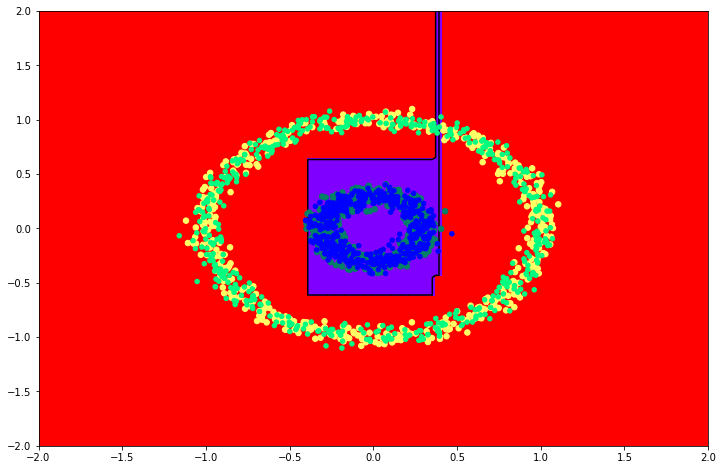

In [80]:
clf5=Tree(criterion="gini",splitter="best",random_state=0,max_depth=5)
clf5.fit(X_train,Y_train)
plot_classifier(clf5,X_train,Y_train,X_test,Y_test,model_type="tree")

Luego de todas las pruebas realizadas podemos comprobar que un árbol de múltiples niveles es capaz de resolver el problema de manera óptima haciendo uso de pocos niveles de profundidad. Además podemos mencionar que nuestro modelo a partir del quinto nivel se comienza a sobre-ajustar, por lo que queda en evidencia la tendencia de los árboles de decisión al sobreajuste. Es por esto que se debe tener cuidado a la hora de seleccionar los parámetros de nuestro árbol y verificar mediante una validación cruzada el comportamiento de estos con el fin de seleccionar dichos parámetros teniendo en cuenta su comportamiento.

### f. Proyección de la data usando kernelPCA

A continuación, se utilizará **Kernel PCA** es decir básicamente PCA pero aplicandole una función de kernel. Este método será utilizado para proyectar cada uno de los datos de entrenamiento y pruebas provenientes de una distribución no lineal, en tan sólo **dos dimensiones** (que para PCA, serán los vectores con direcciones de mayor varianza), Para luego graficar dichas proyección según la clase *target* a la que pertenecen.

In [89]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2,kernel="rbf", gamma=5)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

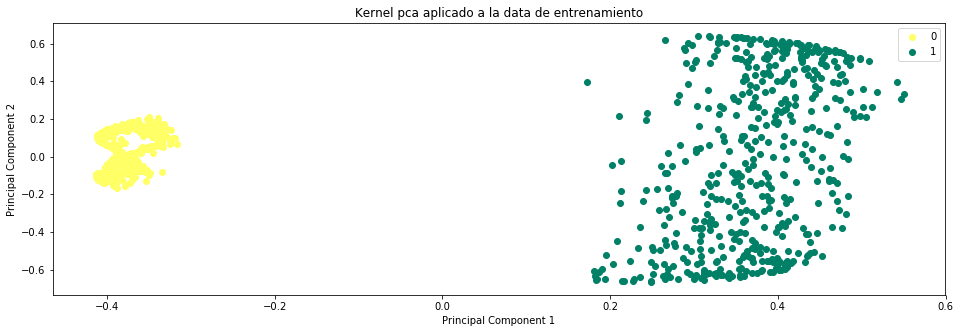

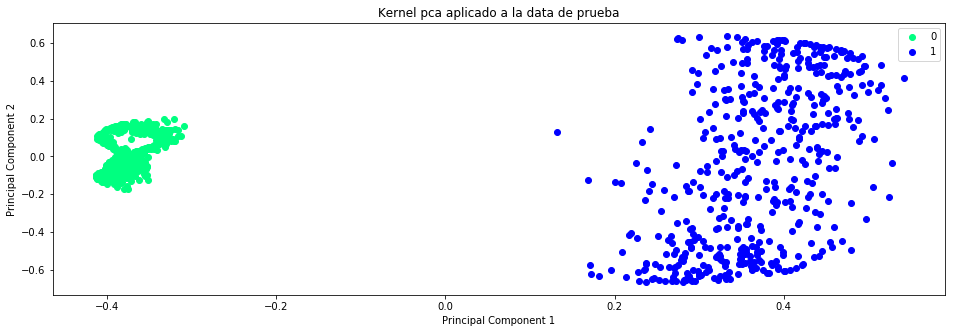

In [90]:
cmap = plt.cm.get_cmap("summer_r")
mclasses = (0,1)
mcolors = [cmap(i) for i in np.linspace(0,1,2)]
plt.figure(figsize=(16,5))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xkpca_train[Y_train==lab, 0], Xkpca_train[Y_train==lab, 1],label=lab,c=col, marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Kernel pca aplicado a la data de entrenamiento")
leg = plt.legend(loc='upper right', fancybox=True)

cmap = plt.cm.get_cmap("winter_r")
mcolors = [cmap(i) for i in np.linspace(0,1,2)]
plt.figure(figsize=(16,5))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xkpca_test[Y_test==lab, 0], Xkpca_test[Y_test==lab, 1],label=lab,c=col, marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Kernel pca aplicado a la data de prueba")
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()


Realizaremos nuevamente el procedimiento, pero esta vez aumentaremos al doble el valor de la varianza de nuestro kernel, descrita por la variable gamma para ver que tanto afecta el comportamiento de KernelPCA

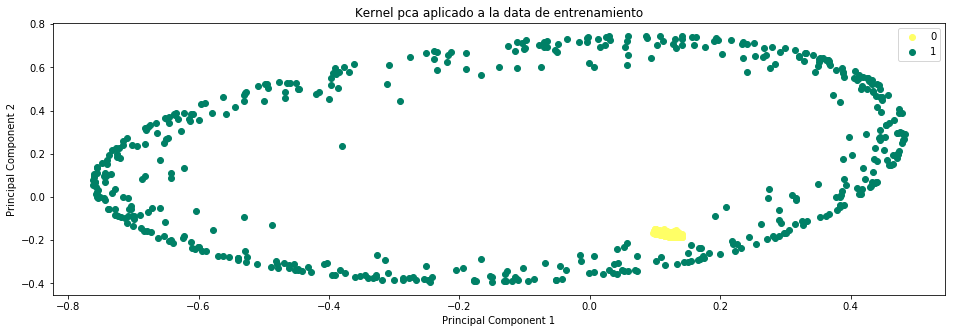

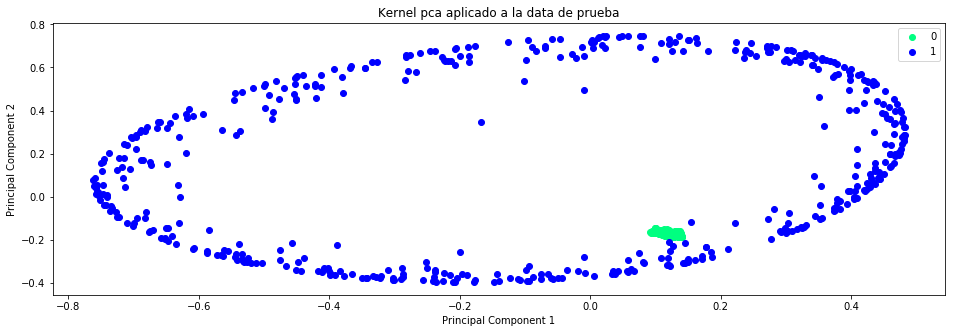

In [100]:
kpca2 = KernelPCA(n_components=2,kernel="rbf", gamma=10)
kpca2 = kpca2.fit(X_train)
Xkpca_train2 = kpca2.transform(X_train)
Xkpca_test2 = kpca2.transform(X_test)

cmap = plt.cm.get_cmap("summer_r")
mclasses = (0,1)
mcolors = [cmap(i) for i in np.linspace(0,1,2)]
plt.figure(figsize=(16,5))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xkpca_train2[Y_train==lab, 0], Xkpca_train2[Y_train==lab, 1],label=lab,c=col, marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Kernel pca aplicado a la data de entrenamiento")
leg = plt.legend(loc='upper right', fancybox=True)

cmap = plt.cm.get_cmap("winter_r")
mcolors = [cmap(i) for i in np.linspace(0,1,2)]
plt.figure(figsize=(16,5))
for lab, col in zip(mclasses,mcolors):
    plt.scatter(Xkpca_test2[Y_test==lab, 0], Xkpca_test2[Y_test==lab, 1],label=lab,c=col, marker='o')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Kernel pca aplicado a la data de prueba")
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

Podemos ver que KernelPCA logra proyectar los datos de entrenamiento y pruebas en las dos dimensiones sin ningun problema para valores de gamma específicos, en nuestro caso gamma = 5, separando de forma perfecta los datos según la clases a la que pertenecen. Por lo tanto, al hacer algún clasificador lineal con estos datos transformados, es esperable que **nos será muy fácil obtener buenos resultados**. 
Sin embargo para otras valores de gamma, como  por ejemplo gamma=10 kernelPCA es incapaz de dividir de forma correcta la data, por lo que la sintonización de este parámetro debe ser considerada y tomada en cuenta a la hora de intentar hacer la transformación de la data. Además cabe mencionar que este comportamiento puede ser debido a que pca es un metodo no supervisado, por lo que no tiene la ayuda de las etiquetas para lograr de mejor forma la división en sus componentes principales. 


### e. Clasificador lineal en datos proyectados por kernel PCA

A continuación usaremos los datos obtenidos con la transformación realizada por KernelPCA, con esto evaluaremos el desempeño de varias maquinas de clasificación lineal, con el fin de comprobar nuestra suposición del punto anterior.

#### Naive Bayes

In [129]:
from sklearn.naive_bayes import BernoulliNB

model6 = BernoulliNB()
model6.fit(Xkpca_train,Y_train)
model6.score(Xkpca_test,Y_test)

1.0

#### SVM lineal

In [140]:
from sklearn.svm import LinearSVC

c = [0.01,0.1,1,10,100]
for i in range(len(c)):
    model7 = LinearSVC(random_state=0,C=c[i])
    model7.fit(Xkpca_train,Y_train)
    print("Accuracy para C=",c[i],":",model7.score(Xkpca_test,Y_test))

Accuracy para C= 0.01 : 1.0
Accuracy para C= 0.1 : 1.0
Accuracy para C= 1 : 1.0
Accuracy para C= 10 : 1.0
Accuracy para C= 100 : 1.0


#### ANN de una sola neurona

In [101]:
model8 = Sequential()
model8.add(Dense(1, input_dim=Xkpca_train.shape[1], kernel_initializer= "uniform", activation="sigmoid"))
model8.compile(optimizer=SGD(lr=1), loss="mean_squared_error", metrics=["accuracy"])
model8.fit(Xkpca_train, Y_train, epochs=50, batch_size=50, verbose=0)
score = model8.evaluate(Xkpca_test, Y_test)
print("\nAccuracy:",score[1])

 928/1000 [==========================>...] - ETA: 0s 
Accuracy: 1.0


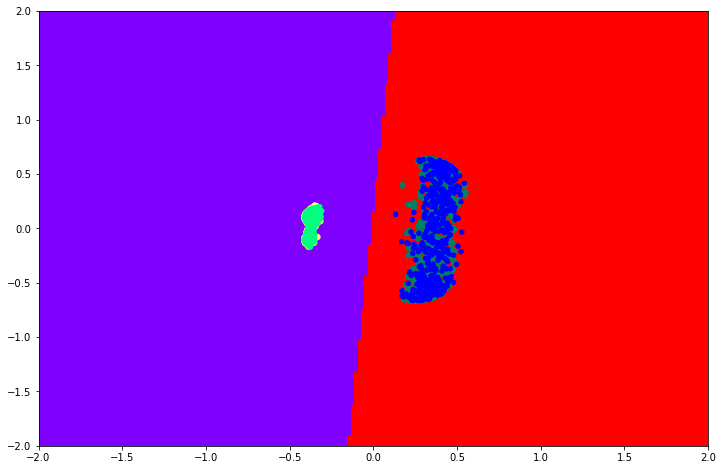

In [103]:
plot_classifier(model8,Xkpca_train,Y_train,Xkpca_test,Y_test,model_type="ann")

Como podemos ver para los tres modelos, se obtuvo un accuracy de 1.0, esto debido a que la data esta perfectamente separada (train y testig) por lo que no hay fuentes de error a la hora de entrenar nuestros modelos.